### memo - how to get required files to run this notebook
```sh
# Get models (for DBFace model, refer to my dbface-on-openvino project to get the model)
python "%INTEL_OPENVINO_DIR%\deployment_tools\tools\model_downloader\downloader.py" --name googlenet-v1,mobilenet-ssd,yolo-v3-tf,ctdet_coco_dlav0_384,human-pose-estimation-0001
python "%INTEL_OPENVINO_DIR%\deployment_tools\tools\model_downloader\converter.py" --name googlenet-v1,mobilenet-ssd,yolo-v3-tf,ctdet_coco_dlav0_384,human-pose-estimation-0001 --precisions FP16
# (Some of) Input files. This doesn't cover all the required files.
copy "%INTEL_OPENVINO_DIR%\deployment_tools\demo\car.png" .
copy "%INTEL_OPENVINO_DIR%\deployment_tools\demo\car_1.bmp" .
copy "%INTEL_OPENVINO_DIR%\deployment_tools\open_model_zoo\demos\python_demos\instance_segmentation_demo\coco_labels.txt" .
```

In [1]:
%matplotlib inline
import numpy as np
import cv2

import matplotlib.pyplot as plt

from openvino.inference_engine import IECore, IENetwork, ExecutableNetwork

In [2]:
# Import 'OpenVINO Model Experiment Package'

import openvino_model_experiment_package as omep

Defined OpenVINO model experiment utility functions


# Image Classification

In [3]:
# Load an IR model
model = 'public/googlenet-v1/FP16/googlenet-v1'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = omep.load_IR_model(model)

Input blobs:  ['data'] [[1, 3, 224, 224]]
Output blobs: ['prob'] [[1, 1000]]


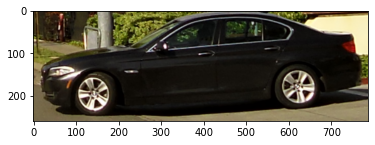

In [4]:
# Load an image and run inference
img_orig = cv2.imread('car.png')
res = omep.infer_ocv_image(exenet, img_orig, inblobs[0])  # Inference

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [5]:
# Decode the inference result and display it
idx = omep.decode_classification_result(res[outblobs[0]])
omep.display_classification_result(res[outblobs[0]], idx, top_k=10, label_file='synset_words.txt')

1 480 0.5016654 car wheel
2 818 0.31316656 sports car, sport car
3 437 0.06171181 beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
4 512 0.048884775 convertible
5 752 0.02398224 racer, race car, racing car
6 469 0.0146776335 cab, hack, taxi, taxicab
7 718 0.010849829 pickup, pickup truck
8 582 0.0068944264 grille, radiator grille
9 706 0.0022261944 passenger car, coach, carriage
10 637 0.0019383883 mailbag, postbag


# Object detection (SSD)

In [6]:
# Load an IR model
model = 'public/mobilenet-ssd/FP16/mobilenet-ssd'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = omep.load_IR_model(model)

Input blobs:  ['data'] [[1, 3, 300, 300]]
Output blobs: ['detection_out'] [[1, 1, 100, 7]]


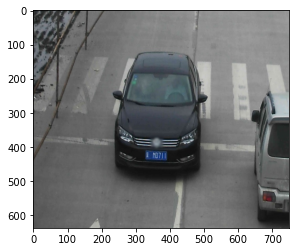

In [7]:
# Load an image and run inference
img_orig = cv2.imread('car_1.bmp')
res = omep.infer_ocv_image(exenet, img_orig, inblobs[0])   # Inference

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [8]:
# Decode the inference result and display it
objs = omep.decode_ssd_result(res[outblobs[0]], threshold=0.8)
print('imgid, clsid, prob, x1, y1, x2, y2')
print(objs)

imgid, clsid, prob, x1, y1, x2, y2
[[0.0, 7.0, 0.9999981, 0.30529332, 0.1880557, 0.6763692, 0.7252005], [0.0, 7.0, 0.8729512, 0.85119945, 0.3870977, 0.99222034, 0.95159996]]


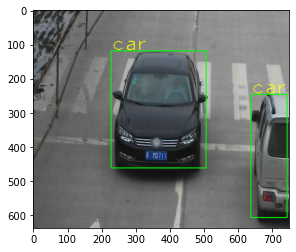

In [9]:
# Display the bbox (bounding box) on the image
omep.display_bboxes(objs, img_orig)

# DBFace (Heatmap, displacement)

In [10]:
# Load an IR model
model = 'dbface-vga/dbface'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = omep.load_IR_model(model)

Input blobs:  ['x'] [[1, 3, 480, 640]]
Output blobs: ['Conv_525', 'Exp_527', 'Sigmoid_526'] [[1, 10, 120, 160], [1, 4, 120, 160], [1, 1, 120, 160]]


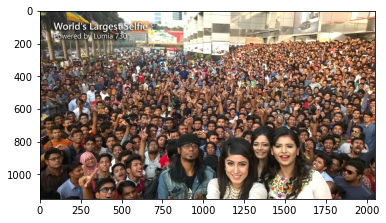

In [11]:
# Load an image and run inference
img_orig = cv2.imread('selfie.jpg')
res = omep.infer_ocv_image(exenet, img_orig, inblobs[0])

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

(1, 10, 120, 160)
0 Raw : min=-0.47, max=0.362, mean=-0.0378
1 Raw : min=-0.306, max=0.488, mean=0.107
2 Raw : min=-0.339, max=0.414, mean=0.0348
3 Raw : min=-0.446, max=0.278, mean=-0.0268
4 Raw : min=-0.375, max=0.482, mean=0.0802
5 Raw : min=-0.621, max=0.358, mean=-0.051
6 Raw : min=-0.641, max=0.369, mean=-0.0489
7 Raw : min=-0.446, max=0.484, mean=0.0697
8 Raw : min=-0.19, max=0.564, mean=0.189
9 Raw : min=-0.137, max=0.593, mean=0.19


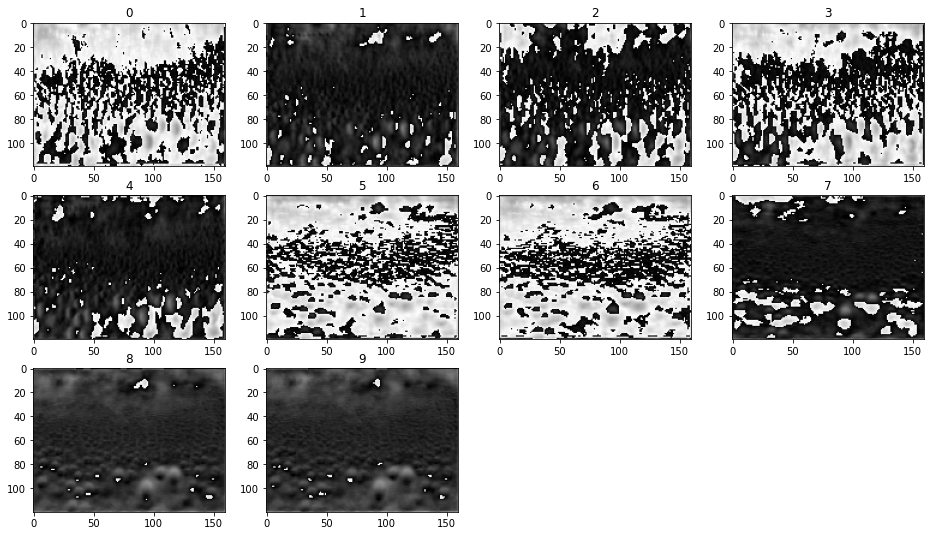

In [12]:
# Display heatmaps
hm = res[outblobs[0]]
print(hm.shape)
omep.display_heatmap(hm)

0 Raw : min=0.00021, max=0.765, mean=0.13


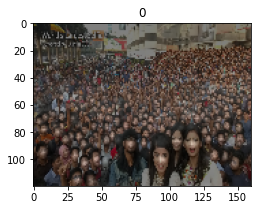

0 Raw : min=0.00021, max=0.765, mean=0.13


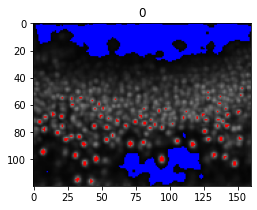

0 Raw : min=0.00021, max=0.765, mean=0.13


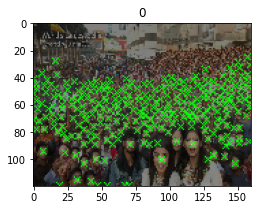

In [13]:
# Display heatmaps
hm = res[outblobs[2]]

# Heatmap overlapped with the original image
omep.display_heatmap(hm, overlay_img=img_orig)

# Heatmap with highlight and lowlight marking
omep.display_heatmap(hm, normalize_flg=True, threshold_l=0.02, threshold_h=0.5)

# Heatmap with peak markers
omep.display_heatmap(hm, overlay_img=img_orig, normalize_flg=True, draw_peaks=True, peak_threshold=0.2)


Max 0.76, Min 0.00021, Mean 0.13, Var 0.015


C:\Users\yas_s\Documents\Intel\OpenVINO\work\openvino-model-experiment-package\openvino_model_experiment_package.py:260: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


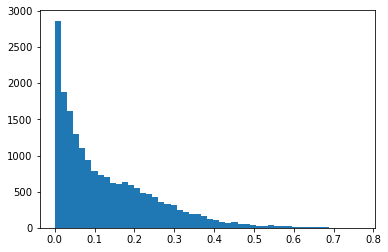

In [14]:
# Display histogram of the heatmap
hm = res[outblobs[2]]
omep.display_statistics(hm)
omep.display_histogram(hm, normalize_flg=False)

# YOLO-v3 (Yolo)

In [15]:
# Load an IR model
model = 'public/yolo-v3-tf/FP16/yolo-v3-tf'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = omep.load_IR_model(model)

Input blobs:  ['input_1'] [[1, 3, 416, 416]]
Output blobs: ['conv2d_58/Conv2D/YoloRegion', 'conv2d_66/Conv2D/YoloRegion', 'conv2d_74/Conv2D/YoloRegion'] [[1, 255, 13, 13], [1, 255, 26, 26], [1, 255, 52, 52]]


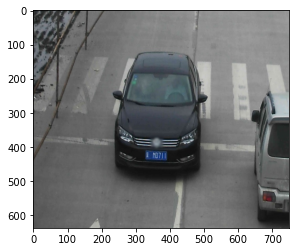

In [16]:
# Load an image and run inference
img_orig = cv2.imread('car_1.bmp')
res = omep.infer_ocv_image(exenet, img_orig, inblobs[0])

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

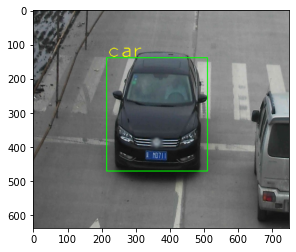

In [17]:
# Decode YOLO v3 result, run NMS to reject overlaping detections, and draw BBoxes
objects = omep.decode_yolo_result(res, net, inshapes, threshold=0.7)
objects = omep.bbox_NMS(objects, threshold=0.7)

omep.display_bboxes(objects, img_orig, label_file='coco_labels.txt')

# CenterNet (Heatmap, offset, box WH)

In [18]:
# Load an IR model
model = 'public/ctdet_coco_dlav0_384/FP16/ctdet_coco_dlav0_384'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = omep.load_IR_model(model)

Input blobs:  ['input.1'] [[1, 3, 384, 384]]
Output blobs: ['508', '511', '514'] [[1, 80, 96, 96], [1, 2, 96, 96], [1, 2, 96, 96]]


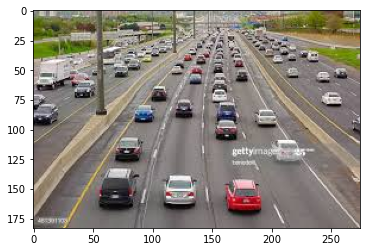

In [19]:
# Load an image and run inference
img_orig = cv2.imread('car1.jpg')
res = omep.infer_ocv_image(exenet, img_orig, inblobs[0])

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

0 Raw : min=0.0, max=1.0, mean=0.541


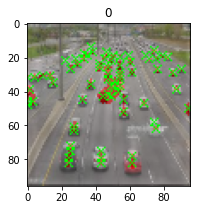

0 Raw : min=0.017, max=0.983, mean=0.5
1 Raw : min=0.0934, max=0.9, mean=0.494


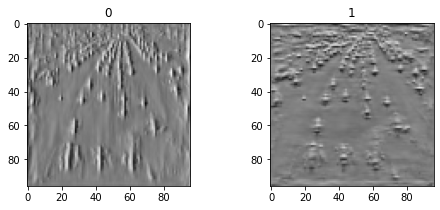

In [20]:
# Normalize heatmap and display with markers
hm = res['508'][:, 2, :, :]
hm = omep.normalize(hm)
omep.display_heatmap(hm.reshape((1,1,96,96)), overlay_img=img_orig, normalize_flg=True, threshold_h=0.7, draw_peaks=True, peak_threshold=0.7)

# Display box size (W,H) map
omep.display_heatmap(res['511'])

31
[[0, 2, 0.6700775, 0.6808127456655105, 0.45690858115752536, 0.746427396312356, 0.5331076557437578], [0, 2, 0.6040169, 0.5567683099458615, 0.5055002588778734, 0.6252405463407437, 0.5927426237612963], [0, 2, 0.5966053, 0.3963820153536896, 0.752273510210216, 0.5035714719754955, 0.9024613602086902], [0, 2, 0.57376873, -0.0011740047484636307, 0.4370915669326981, 0.07615561100343864, 0.5304107346261541], [0, 2, 0.55185837, 0.4298174704114596, 0.4130967129021883, 0.4934758320450783, 0.49333215442796546], [0, 2, 0.5481247, 0.5462734332929055, 0.361882282110552, 0.5934490195165077, 0.419051982772847], [0, 2, 0.54101574, 0.28478426951915026, 0.2336299686382214, 0.32912704565872747, 0.27413675871988136], [0, 2, 0.53431225, 0.3065108402321736, 0.43662069613734883, 0.3713656608015299, 0.5136216717461745], [0, 2, 0.5342944, 0.8791237709422907, 0.37379790749400854, 0.9469057259460291, 0.4421403349066774], [0, 2, 0.50485015, 0.8644288405776024, 0.2818562872707844, 0.9123469615976015, 0.335457875082

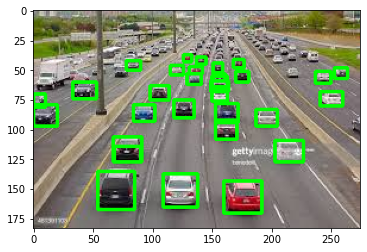

In [21]:
# Display BBox without class labels
objects = omep.decode_centernet(res['508'], res['511'], res['514'], threshold=0.3)
print(len(objects))
print(objects)
omep.display_bboxes(objects, img_orig, disp_label=False)

# Human-pose-estimation-0001 (Heatmap, PAF)

In [22]:
# Load an IR model
model = 'intel/human-pose-estimation-0001/FP16/human-pose-estimation-0001'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = omep.load_IR_model(model)

Input blobs:  ['data'] [[1, 3, 256, 456]]
Output blobs: ['Mconv7_stage2_L1', 'Mconv7_stage2_L2'] [[1, 38, 32, 57], [1, 19, 32, 57]]


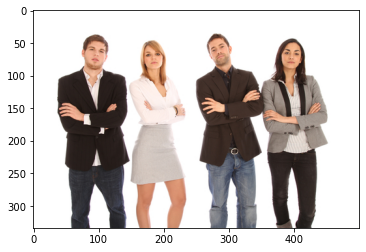

In [23]:
# Load an image and run inference
img_orig = cv2.imread('people.jpg')
res = omep.infer_ocv_image(exenet, img_orig, inblobs[0])

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Heatmaps (HM)


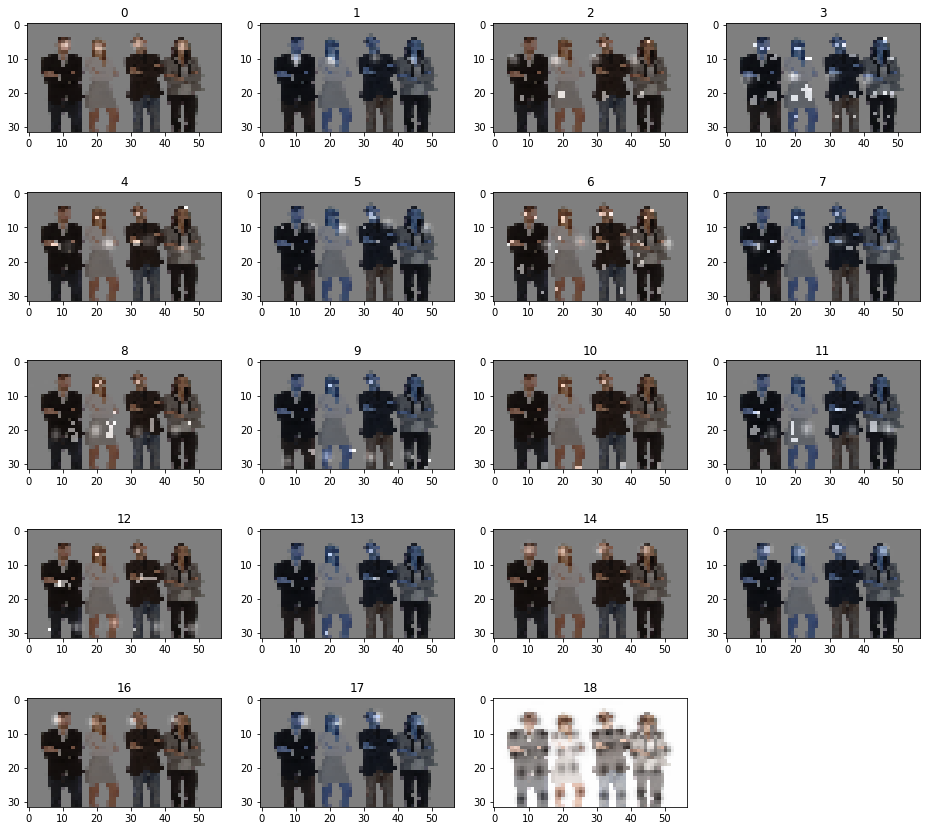

In [24]:
print('Heatmaps (HM)')
omep.display_heatmap(res['Mconv7_stage2_L2'], overlay_img=img_orig, statistics=False)

Pair Affinity Field (PAF)
0 Raw : min=-0.213, max=0.0175, mean=-0.00673
1 Raw : min=-0.0446, max=1.1, mean=0.0503
2 Raw : min=-0.0874, max=0.0837, mean=-0.000226
3 Raw : min=-0.0147, max=1.01, mean=0.0362
4 Raw : min=-0.071, max=0.265, mean=0.00192
5 Raw : min=-0.0117, max=0.974, mean=0.0175
6 Raw : min=-0.0169, max=0.376, mean=0.0146
7 Raw : min=-0.0308, max=1.11, mean=0.0524
8 Raw : min=-0.0285, max=0.303, mean=0.00534
9 Raw : min=-0.014, max=1.06, mean=0.0391
10 Raw : min=-0.31, max=0.0616, mean=-0.00133
11 Raw : min=-0.00733, max=0.974, mean=0.0162
12 Raw : min=-1.06, max=0.00539, mean=-0.0203
13 Raw : min=-0.0144, max=0.142, mean=0.00108
14 Raw : min=-0.0933, max=0.338, mean=0.00325
15 Raw : min=-0.00554, max=1.05, mean=0.0284
16 Raw : min=-0.00874, max=1.1, mean=0.0274
17 Raw : min=-0.187, max=0.217, mean=-0.0008
18 Raw : min=-0.0129, max=0.564, mean=0.00824
19 Raw : min=-0.862, max=0.00398, mean=-0.02
20 Raw : min=-0.0203, max=1.06, mean=0.0203
21 Raw : min=-0.17, max=0.017, mea

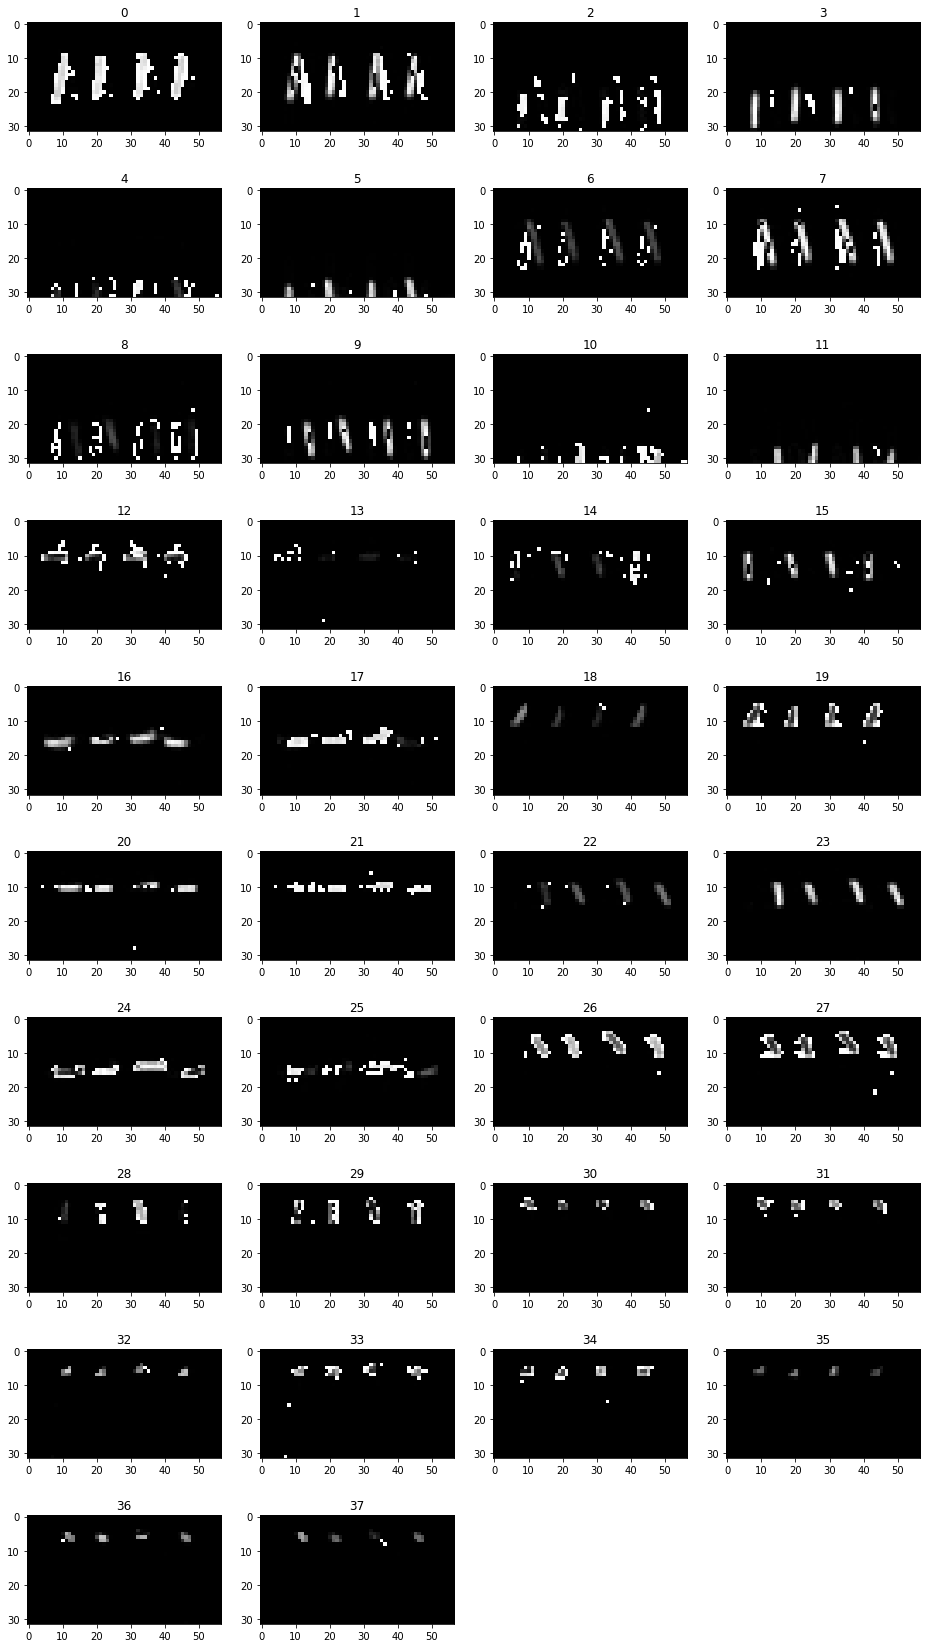

In [25]:
print('Pair Affinity Field (PAF)')
omep.display_heatmap(res['Mconv7_stage2_L1'], normalize_flg=False, statistics=True)